In [1]:
from typing import List, Tuple, Dict

import matplotlib.pyplot as plt

import os 
import sys
import numpy as np
import pandas as pd

import torch

import re
import glob
import h5py

from dataclasses import dataclass, InitVar

In [2]:
#import utilities from the protml package
base_path = os.getcwd()
sys.path.append(base_path)

import protml
from protml.models import VAE, ENC_M, ENC_M_dz
from protml.dataloaders import (
                                SequenceDataModule, 
                                Sequence_WT_DataModule,
                                EmbeddingsDataModule, 
                                Embeddings_WT_Dataset
)

from protml.dataloaders.utils import pad_sequence


## Brief Description of the input datasets
The dataset contains $\Delta \Delta G$ scores for a large number of protein sequence variants.  $\Delta \Delta G$  measures the free energy change for unfolding a protein variant, compared to the change for unfolding the corresponding wild type. Aim of the project, is the prediction of this free energy change, for a given sequence relative to its wildtype. 

In this notebook we take a closer look at the sequence data. 

1) load and analyze the processed ML dataset (Processed_K50_dG_datasets/Dataset_1_2_processed.csv)
2) preparing input data for ML models
3) outline of the modelling strategy


## Creating a cover image

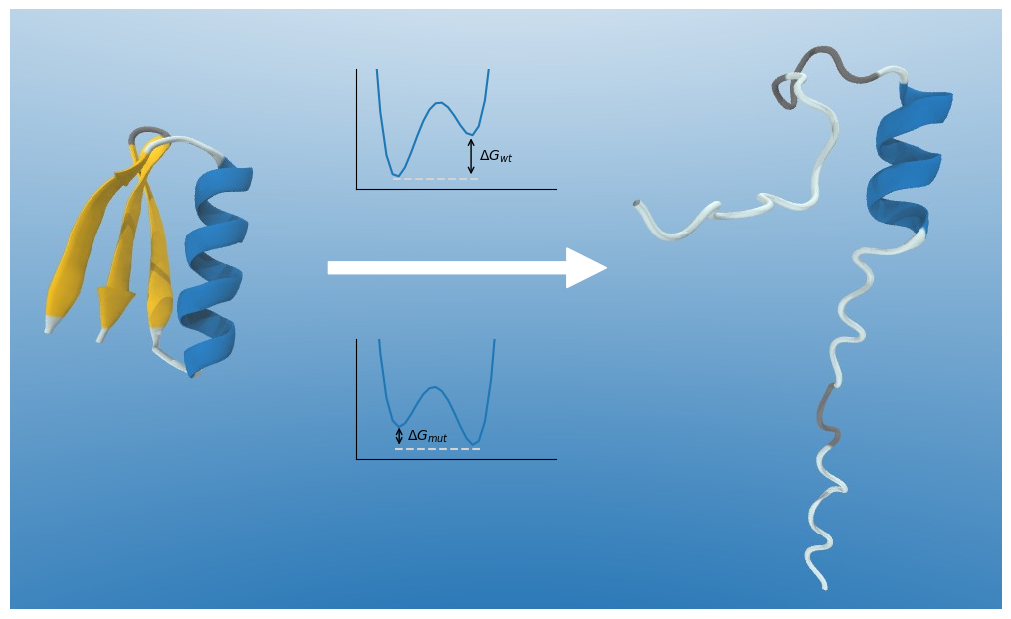

In [3]:
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.patches as patches

#function to represent a double well free energy landscape
# 
def double_well(x, a1, a2, a3, a4, a5):
     return a1*pow((x),4) + a2*pow(x,3) + a3*pow(x,2) + a4*x +a5

def float_ax(ypos:float, ylim:Tuple[float,float]=(-3,4)):
     ax = fig.add_axes([0.35,ypos,0.2,0.2], facecolor = (1,1,1,0))
     ax.spines['top'].set_visible(False)
     ax.spines['right'].set_visible(False)
     ax.set_ylim(ylim[0],ylim[1])
     ax.set_xlim(-2,3)
   
     ax.set_xticks([])
     ax.set_yticks([])

     return ax

def annotate_DG( ax:plt.Axes, x_vals:List[int], y_vals:List[int], e_ndx:int, text:str)->None:
     # add arrows and text to the free energy landscape
     arrow_point1 = (x_vals[e_ndx], y_vals[0])
     arrow_point2 = (x_vals[e_ndx], y_vals[1])
     line_x = (x_vals[0]-0.1, x_vals[1]+0.2)
     line_y = (y_vals[1]-0.1, y_vals[1]-0.1)
     p1 = patches.FancyArrowPatch(arrow_point1, arrow_point2, mutation_scale=10, arrowstyle="<->")
     ax.plot(line_x, line_y, linestyle="dashed", color="lightgrey")
     ax.add_patch(p1)
     ax.annotate(text, xy = ((arrow_point1[0]+0.2,(arrow_point1[1]+arrow_point2[1])/2-0.2)))


x_vals = np.linspace(-2,4,40)

#create the title pictures
img = plt.imread(os.path.join(base_path, "Data", "images", "tach-1.png"), format="bmp")
fig = plt.figure(figsize=(10, 6)) 

ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])
ax.imshow(img, interpolation='none')
plt.arrow(320,260,240,0, width=12, head_width=40, head_length = 40, color = 'w')

ax_f = float_ax(0.7)
ax_f.plot(x_vals, double_well(x_vals, 4, 0, -7.0, 1.3, 2))

#add patches: arrow to mark DG and dashed line at global minimum
#get teh points for arrow tips from the extrema
extrema = np.roots(np.polyder([4, 0, -7.0, 1.3, 2]))
x_e = (extrema[0], extrema[1])
y_vals = [double_well(extrema[1], 4, 0, -7.0, 1.3, 2), double_well(extrema[0], 4, 0, -7.0, 1.3, 2)]
annotate_DG(ax_f, x_e, y_vals, 1, r"$\Delta G_{wt}$")


#add the mutated free energy landscape with global minimum at the unfolded state
ax_f2 = float_ax(0.25, ylim=(-3.5,4))
ax_f2.plot(x_vals, double_well(x_vals, 4, 0, -7.0, -0.6, 1))

extrema2 = np.roots(np.polyder([4, 0, -7.0, -0.6, 1]))
x_e2 = (extrema2[1], extrema2[0])
y_vals2 = [double_well(extrema2[1], 4, 0, -7.0, -0.6, 1)+0.15, double_well(extrema2[0], 4, 0, -7.0, -0.6, 1)-0.15]
annotate_DG(ax_f2, x_e2, y_vals2, 0 , r"$\Delta G_{mut}$")

plt.savefig(os.path.join(base_path, "Data", "images", "cover.jpeg"), dpi=300, bbox_inches='tight')

## 1) Analyzing the mega-scale protein stability dataset 

In [4]:

data_dir = 'Data'
DS_1_2 = pd.read_csv(os.path.join(data_dir, 'Processed_K50_dG_datasets','K50_dG_Dataset1_Dataset2.csv'),
                     dtype=object,
                     usecols=['name', 'aa_seq', 'mut_type','WT_name', 'WT_cluster', 'dG_ML', 'ddG_ML']
                     )
print(DS_1_2.shape)
DS_1_2.head()

(851552, 7)


,name,aa_seq,mut_type,WT_name,WT_cluster,dG_ML,ddG_ML
0,1GYZ.pdb,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,wt,1GYZ.pdb,100,4.091166449880765,0.08284360826877712
1,1GYZ.pdb,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,wt,1GYZ.pdb,100,4.093462527983947,0.08513968637195912
2,1GYZ.pdb_wtm,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,wt,1GYZ.pdb,100,3.938306149734356,-0.07001669187763193
3,1GYZ.pdb_wte,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,wt,1GYZ.pdb,100,4.051388395402071,0.04306555379008348
4,1GYZ.pdb_wty,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,wt,1GYZ.pdb,100,3.965257287821904,-0.04306555379008392


In [5]:
# remove rows with low quality data marked with '-' by the authors and get data info
DS_1_2 = DS_1_2[DS_1_2.ddG_ML!='-']
DS_1_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 586938 entries, 0 to 803153
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   name        586938 non-null  object
 1   aa_seq      586938 non-null  object
 2   mut_type    586938 non-null  object
 3   WT_name     586938 non-null  object
 4   WT_cluster  586938 non-null  object
 5   dG_ML       586938 non-null  object
 6   ddG_ML      586938 non-null  object
dtypes: object(7)
memory usage: 35.8+ MB


In [6]:
#convert the numeric data types
DS_1_2['ddG_ML'] = DS_1_2.ddG_ML.astype(float)
DS_1_2['dG_ML'] = DS_1_2.dG_ML.astype(float)

### Data value distributions


First we take a closer look at the score column i.e. our target variable values.

<Axes: ylabel='Frequency'>

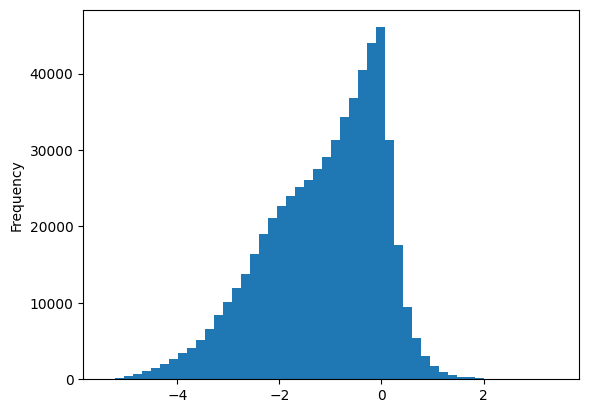

In [7]:
DS_1_2.ddG_ML.plot.hist(bins=50)

 The score distribution is skewed. As we are dealing with relative free energies, the value of 0 corresponds to the wild type score. Clearly there are not many variants that lead to greater protein stability, whereas some variants can strongly destabilize the folded state. 

 Standard or minmax scaling will have the side effect of moving the maximum of the away from zero. 
 An alternative is to scale by the negative half of a standard scaler: use the negative part of the distribution to calculate a (pseudo) standart deviation as 
 $std_{pseudo} = \sqrt (\sum (y²))$ for all $y<0$ 

<Axes: ylabel='Frequency'>

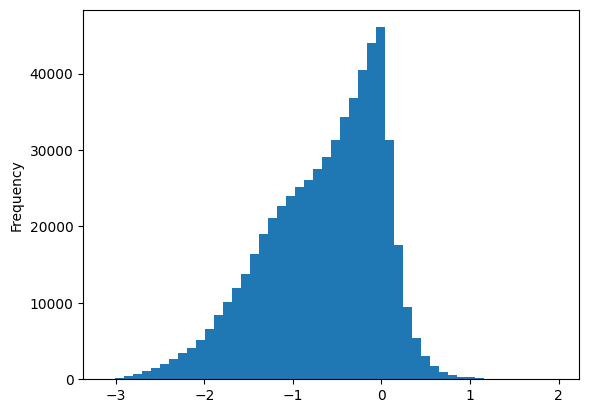

In [8]:
#create a pseudo std for the  negative tail for scaling. 
pseudo_std = np.sqrt(sum(np.power(DS_1_2[DS_1_2.ddG_ML <=0]['ddG_ML'],2))/len(DS_1_2[DS_1_2.ddG_ML <=0]))

#look at the scaled data distribution
DS_1_2['score_scaled'] = DS_1_2['ddG_ML']/pseudo_std
DS_1_2.score_scaled.plot.hist(bins=50)

The stability of a protein is closely linked to the probability of it's existence in the cell. Denatured proteins are easily degraded by autophagy. Many high throughput assays for protein variants exploit this relation. In many assays it is assumed that stability is the only factor which can be inferred from number counts. (e.g. https://doi.org/10.1016/j.celrep.2021.110207 ) 

Following this assumption, we can use the Boltzmann factor  $\propto \exp(-\Delta\Delta G)$ to represent the probability of observing a given variant relative to the wt. In a generative model, this can be used in the sampling probability instead of using MSA. 

The distribution of probabilities: 

(0.0, 3.0)

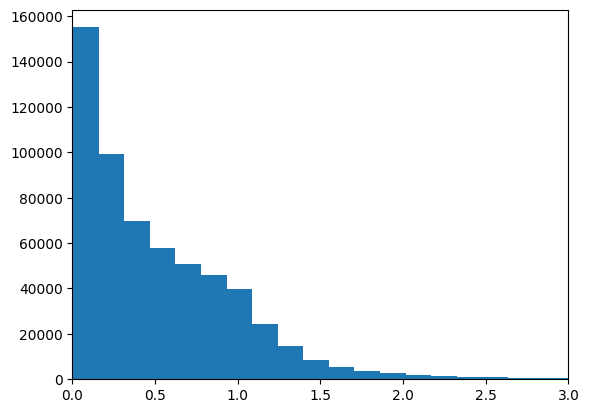

In [9]:
fig, ax = plt.subplots(1,1)

proba = np.exp(DS_1_2.ddG_ML)
ax.hist(proba, bins=200)
ax.set_xlim(0,3)

#### other properties: sequence length and amino acid content 

72 29


<Axes: ylabel='Frequency'>

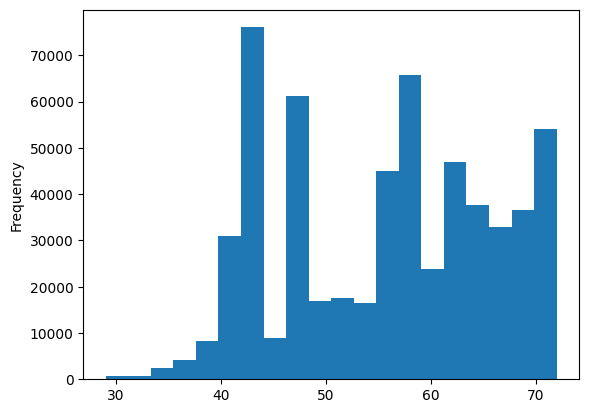

In [10]:
#get the range of sequence lengths and distribution
print(DS_1_2.aa_seq.apply(len).max(), DS_1_2.aa_seq.apply(len).min())
DS_1_2.aa_seq.apply(len).plot.hist(bins=20)

All protein sequences in the set are comparatively short, between 30 and 72 AA. short sequences keep the array sizes reasonable and allow the use of smaller model sizes, the longest possible correlations are of the order of the sequence length. 

20 amino acids found


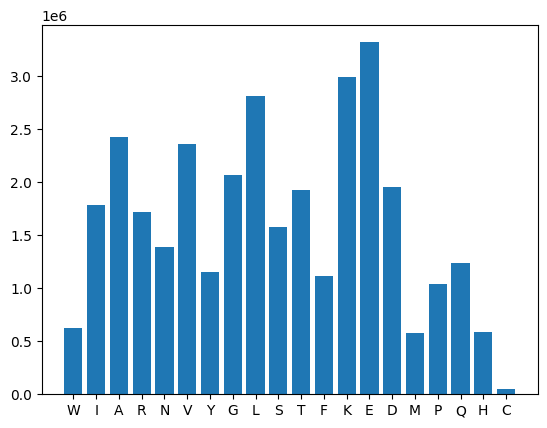

In [11]:
from collections import Counter
def compute_aminoacids_freq(df):
    freq_per_acid = Counter("".join(df["aa_seq"]))
    return dict(freq_per_acid)

amino_acids_freq = compute_aminoacids_freq(DS_1_2)
print( len(amino_acids_freq), 'amino acids found')
plt.bar(range(len(amino_acids_freq)), list(amino_acids_freq.values()), align='center')
plt.xticks(range(len(amino_acids_freq)), list(amino_acids_freq.keys()))

plt.show()

In [12]:
print('rarest AA: ', amino_acids_freq['C'])

rarest AA:  53589


There are no non-standard Amino acids; even the least frequent AA (C) has over 50000 occurences.  

## 2) Preparing the datasets for modelling

We follow the below steps: 
- pad the sequences to the same lenth (constant input dimensions)
- find and pad the wild type sequence for each protein.
- split the data:
    - take out proteins from training data for test/evaluation of models on unseen data
    - create train/validation splits
- create a few single protein traiin/validation sets, for comarison to protein specific models in the literature and quick optimization. 


In [13]:
protein_names = DS_1_2.WT_name.unique() 

#Pad all sequences to the same length and add column
max_length = 72
seq_list = DS_1_2.aa_seq.to_list()
DS_1_2['padded_seq'] = [pad_sequence(s,max_length) for s in seq_list]

# split the mut_type column (variant specification) to extract the WT AA, and the position. 
# we'll use this to reconstruct the wild type sequence. 
mut_list = [re.findall('([A-Za-z])([0-9]+)([A-Za-z])', s)  for s in DS_1_2['mut_type']]
# treat the indels separately
indel_list = [re.findall('(ins|del)([A-Za-z])([0-9]+)',s) for s in DS_1_2['mut_type']]


# Initialize the MUT, WT  and position columns as empty lists. We use list forms,
#  because some measurements contain more than one variant.
list_list = [[ [] for _ in range(len(DS_1_2)) ], [ [] for _ in range(len(DS_1_2)) ],[ [] for _ in range(len(DS_1_2)) ]]

for i,(mut,indel) in enumerate(zip(mut_list,indel_list)):
    for m in mut:
        list_list[0][i].append(m[0])
        list_list[1][i].append(int(m[1]))
        list_list[2][i].append(m[2])
    # add the indels
    for ind in indel:
        list_list[1][i].append(int(ind[2]))
        #append the inserted aminoaccid for the new sequence
        if ind[0] == 'ins':
            list_list[2][i].append(ind[1])
        elif ind[0] == 'del':
            list_list [0][i].append(ind[1])
        
       
DS_1_2['WT'] = list_list[0]
DS_1_2['pos'] = list_list[1]
DS_1_2['MUT'] = list_list[2]

# Number of distinct proteins in the set and number of proteins with listed wt sequences
print('mutation type = wt: ', len(DS_1_2[DS_1_2.mut_type == 'wt'].WT_name .unique()))
print('unique proteins:',len(protein_names))

mutation type = wt:  396
unique proteins: 396


There is a wild type in the set for each protein name. 

In [14]:
# the  aa sequences in the dataframe are the mutated ones. 
# reconstruct the wt sequence and verify that it matches wt if available

#function that inverts the variants to get the wt seq back
def make_WT (seq:str, pos:List[int], WTs:List[str], AAs:List[str])->str:
    wt_seq = seq
    #print(len(WTs), len(AAs))
    if len(WTs) == len(AAs):
        #replace AA by WT_AA
        for p,aa in zip(pos, WTs):
            wt_seq = wt_seq[:p-1] + aa + wt_seq[p:]
            
    elif len(WTs) > len(AAs): 
        #reinsert the deletions
        for p,aa in zip(pos, WTs):
            wt_seq = wt_seq[:p-1] + aa + wt_seq[p-1:]
    
    elif len(WTs) < len(AAs): 
        #delete the insertions
        for p,aa in zip(pos, AAs):
            wt_seq = wt_seq[:p-1] + wt_seq[p:]

    return wt_seq

#find string position where the sequence is different from the WT
def find_diff_pos(seq:str, WT:str)->List[int]:
    return [ i+1 for i,(s,wt) in enumerate(zip(seq,WT)) if  s!= wt]
  
  
#this breake down for the 2nd protein name. 
mismatch_lines = []
for prot in protein_names:
    ndcs = DS_1_2[DS_1_2.WT_name == prot].index.to_list()
    wt_ref = DS_1_2.loc[ndcs[0],'aa_seq']
    for n in ndcs[1:]:
        r = DS_1_2.loc[n] 
        wt_seq = make_WT(r['aa_seq'], r.pos, r.WT, r.MUT)
        if  wt_ref != wt_seq:
            mismatch_lines.append([prot, n, r.mut_type, r.pos, r.WT, r.MUT])

print( 'there are ', len(mismatch_lines), ' lines that do not match the wt')

there are  1682  lines that do not match the wt


In [15]:
[i for i in mismatch_lines[:10] if not i[2].startswith('ins') ]

[]

In [16]:
DS_1_2[DS_1_2.WT_name.str.contains('EHEE_rd4')]

,name,aa_seq,mut_type,WT_name,WT_cluster,dG_ML,ddG_ML,score_scaled,padded_seq,WT,pos,MUT
314726,EEHEE_rd4_0481.pdb,KTVHVNGVQYDFDNPEQAERFAKEMAKKAGLQIQFHGDQIKIE,wt,EEHEE_rd4_0481.pdb,EEHEE,1.032432,-0.746955,-0.430289,KTVHVNGVQYDFDNPEQAERFAKEMAKKAGLQIQFHGDQIKIE---...,[],[],[]
314727,EEHEE_rd4_0481.pdb,KTVHVNGVQYDFDNPEQAERFAKEMAKKAGLQIQFHGDQIKIE,wt,EEHEE_rd4_0481.pdb,EEHEE,0.849712,-0.929676,-0.535547,KTVHVNGVQYDFDNPEQAERFAKEMAKKAGLQIQFHGDQIKIE---...,[],[],[]
314728,EEHEE_rd4_0481.pdb,KTVHVNGVQYDFDNPEQAERFAKEMAKKAGLQIQFHGDQIKIE,wt,EEHEE_rd4_0481.pdb,EEHEE,1.412292,-0.367096,-0.211468,KTVHVNGVQYDFDNPEQAERFAKEMAKKAGLQIQFHGDQIKIE---...,[],[],[]
314729,EEHEE_rd4_0481.pdb_wte,KTVHVNGVQYDFDNPEQAERFAKEMAKKAGLQIQFHGDQIKIE,wt,EEHEE_rd4_0481.pdb,EEHEE,1.779388,0.000000,0.000000,KTVHVNGVQYDFDNPEQAERFAKEMAKKAGLQIQFHGDQIKIE---...,[],[],[]
314730,EEHEE_rd4_0481.pdb_wty,KTVHVNGVQYDFDNPEQAERFAKEMAKKAGLQIQFHGDQIKIE,wt,EEHEE_rd4_0481.pdb,EEHEE,1.810821,0.031433,0.018107,KTVHVNGVQYDFDNPEQAERFAKEMAKKAGLQIQFHGDQIKIE---...,[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...
397633,EHEE_rd4_0340.pdb_K40P,EINVTSHGEEQAKHWIELAKRMNLDVEVEIHGDKIIITIP,K40P,EHEE_rd4_0340.pdb,EHEE,0.108826,-1.238329,-0.713349,EINVTSHGEEQAKHWIELAKRMNLDVEVEIHGDKIIITIP------...,[K],[40],[P]
397634,EHEE_rd4_0340.pdb_K40C,EINVTSHGEEQAKHWIELAKRMNLDVEVEIHGDKIIITIC,K40C,EHEE_rd4_0340.pdb,EHEE,1.492874,0.145719,0.083943,EINVTSHGEEQAKHWIELAKRMNLDVEVEIHGDKIIITIC------...,[K],[40],[C]
397635,EHEE_rd4_0340.pdb_insG40,EINVTSHGEEQAKHWIELAKRMNLDVEVEIHGDKIIITIGK,insG40,EHEE_rd4_0340.pdb,EHEE,1.022422,-0.324733,-0.187065,EINVTSHGEEQAKHWIELAKRMNLDVEVEIHGDKIIITIGK-----...,[],[40],[G]
397636,EHEE_rd4_0340.pdb_insA40,EINVTSHGEEQAKHWIELAKRMNLDVEVEIHGDKIIITIAK,insA40,EHEE_rd4_0340.pdb,EHEE,0.967840,-0.379315,-0.218507,EINVTSHGEEQAKHWIELAKRMNLDVEVEIHGDKIIITIAK-----...,[],[40],[A]


All problems occur for insertions. Let's take a closer look at these: 

In [17]:
type(DS_1_2.loc[ndcs[0], 'aa_seq'])

str

In [18]:
#checking the marked insertions
ndcs = DS_1_2[DS_1_2.WT_name == protein_names[2]].index.to_list()
loc_val = 2631

new_var = DS_1_2.loc[loc_val, 'aa_seq']
print(find_diff_pos(DS_1_2.loc[ndcs[0], 'aa_seq'], new_var[:]))


print(DS_1_2.loc[ndcs[0], 'aa_seq'])   
print(DS_1_2.loc[loc_val, 'aa_seq'])   
print(DS_1_2.loc[loc_val, 'WT'], DS_1_2.loc[loc_val, 'pos'], DS_1_2.loc[loc_val, 'MUT'])  

print(make_WT(DS_1_2.loc[loc_val, 'aa_seq'], DS_1_2.loc[loc_val, 'pos'], DS_1_2.loc[loc_val, 'WT'], DS_1_2.loc[loc_val, 'MUT']))

[1, 2, 3]
QVNIAPGSLDKALNQYAAHSGFTLSVDASLTRGKQSNGLHGDYDVESGLQQLLDGSGLQVKPLGNNSWTLEP
VNGIAPGSLDKALNQYAAHSGFTLSVDASLTRGKQSNGLHGDYDVESGLQQLLDGSGLQVKPLGNNSWTLEP
[] [3] ['G']
VNIAPGSLDKALNQYAAHSGFTLSVDASLTRGKQSNGLHGDYDVESGLQQLLDGSGLQVKPLGNNSWTLEP


these are the same length as wt ... missing AA or really a mutation?
create a reference wt for each protein type.

In [19]:
# For the per residue and per protein datasplits,
# collect info for each protein in the set and unique (protein,position)
#  assumption: single mutation data -> there is a unique wt sequence for each pdb id. 
# (in fact this is not strictly true )  

@dataclass
class protein:
    name: str
    wt: str 
    seq_len: int 

#for all proteins, check if there is a wt sequence available, otherwise use the first mutation to create a ref wt sequence

protein_dict = {}
for prot in protein_names:
    if len(DS_1_2[(DS_1_2.WT_name == prot) & (DS_1_2.mut_type == 'wt')])>0:
        wt_ref = DS_1_2[(DS_1_2.WT_name == prot) & (DS_1_2.mut_type == 'wt')].iloc[0]['aa_seq']
        protein_dict[prot] = protein(name=prot , wt= wt_ref,  seq_len=len(wt_ref))
    elif len(DS_1_2[(DS_1_2.WT_name == prot) & ~(DS_1_2.mut_type.str.contains('ins|del'))])>0:
        ref = DS_1_2[(DS_1_2.WT_name == prot) & ~(DS_1_2.mut_type.str.contains('ins|del'))].iloc[0]
        wt_ref = make_WT(ref.aa_seq, ref.pos, ref.WT, ref.MUT)
        protein_dict[prot] = protein(name=prot, wt=wt_ref, seq_len=len(wt_ref))
    else:
        print('error finding wt for',prot)
print(len(protein_dict))


396


check for missing residues  mutations/insertions

In [20]:
#validate sequence length matches mut_type label 
def validate_mut_type(mut_type:str, aa_seq:str, prot:str, prot_info:protein)->bool:
    if mut_type == 'wt':
        if len(prot_info.wt) != prot_info.seq_len:
            return False
    elif 'del' in mut_type:
        if not len(aa_seq) < prot_info.seq_len:
           return False
    elif 'ins' in mut_type:
        if not len(aa_seq) >  prot_info.seq_len:
           return False
    else:
        if len(aa_seq) != prot_info.seq_len:
            return False
    return True

length_check = DS_1_2.apply(lambda x: validate_mut_type(x.mut_type, x.aa_seq, x.WT_name, protein_dict[x.WT_name]), axis=1)
print(length_check.value_counts())

print(DS_1_2[~length_check.values].WT_name.unique())
print(DS_1_2[~length_check.values].mut_type.unique())

True     585256
False      1682
Name: count, dtype: int64
['2D1U.pdb' '2LT1.pdb' '1O6X.pdb' '3DKM.pdb' '1UFM.pdb' '2AMI.pdb'
 '1UBQ.pdb_L67S' '1UBQ.pdb_L43A' '1UBQ.pdb_L15S' '1UBQ.pdb_I3A'
 '2MLB.pdb_L43D' '2N7Y.pdb']
['insA1' 'insG2' 'insA2' 'insG3' 'insA3' 'insG4' 'insA4' 'insG5' 'insA5'
 'insG6' 'insA6' 'insG7' 'insA7' 'insG8' 'insA8' 'insG9' 'insA9' 'insG10'
 'insA10' 'insG11' 'insA11' 'insG12' 'insA12' 'insG13' 'insA13' 'insG14'
 'insA14' 'insG15' 'insA15' 'insG16' 'insA16' 'insG17' 'insA17' 'insG18'
 'insA18' 'insG19' 'insA19' 'insG20' 'insA20' 'insG21' 'insA21' 'insG22'
 'insA22' 'insG23' 'insA23' 'insG24' 'insA24' 'insG25' 'insA25' 'insG26'
 'insA26' 'insG27' 'insA27' 'insG28' 'insA28' 'insG29' 'insA29' 'insG30'
 'insA30' 'insG31' 'insA31' 'insG32' 'insA32' 'insG33' 'insA33' 'insG34'
 'insA34' 'insG35' 'insA35' 'insG36' 'insA36' 'insG37' 'insA37' 'insG38'
 'insA38' 'insG39' 'insA39' 'insG40' 'insA40' 'insG41' 'insA41' 'insG42'
 'insA42' 'insG43' 'insA43' 'insG44' 'insA44' 'insG

There are 1682 mutations labeled insertions though the sequence is the same length as the wt.
 all of them are single insertions. 

We will go with the sequences in the datafile.

In [21]:
#check that all data for which the lenth checks match wt
# all indices of 1st protein name

for n,r in DS_1_2[length_check.values].iterrows():
    if protein_dict[r.WT_name].wt != make_WT(r['aa_seq'], r.pos, r.WT, r.MUT):
        print(n, r.WT_name, r.pos, r.WT, r.MUT)

# ok

In [22]:
# check that the mismatch for the problem cases is always the first residue
for n,r in DS_1_2[~length_check.values].iterrows():
    if protein_dict[r.WT_name].wt[1:] != make_WT(r['aa_seq'], r.pos, r.WT, r.MUT):
        print(n, r.WT_name, r.pos, r.WT, r.MUT)

# also ok

In [23]:
#a list of proteins with missmatches
mismatch_prot = DS_1_2[~length_check.values].WT_name.unique()

In [24]:
# add the corresponding padded wt sequence to each data line, 
# the difference from wt may serve as additional features
# for the missmatches remove the first AA 

DS_1_2['wt_p'] = DS_1_2.apply(lambda x: pad_sequence(make_WT(x['aa_seq'], x.pos, x.WT, x.MUT), max_length), axis=1)

#save the processed dataset for further use
DS_1_2.to_csv('Data/Dataset_1_2_processed.csv', index=False)

### Now we can create our different split datasets

### Protein specific data split considerations: 

a random dataset split may lead to considerable data leaks, because mutations in the same position are likely to have correlated effects. 

Alternatively we can consider  a 'per residue' split or a 'per protein' split chould be considered. On the other hand, the latter would require models to perform a very high degree of extrapolation, which is likely not ideal as validation. However some proteins may be held out for testing on unseen data. 

In [25]:
from torch.utils.data import random_split

# To prevent data leakage, we need to split the data at the residue or protein level

# create a list of protein position pairs for the residue level split, 
#protein_position_pairs = [(p, i+1) for p, prot in protein_dict.items() for i in range(prot.seq_len)]

#get the total numbers for each split type
N_proteins = len(protein_dict)
#N_total_res_positions = len(protein_position_pairs)
N_mutations = len(DS_1_2)

# first withhold some (6) proteins from training completely. Use seed for reprducible split
N_withheld = 6
rndn_generator = torch.Generator().manual_seed(42)
proteins_train, proteins_test = random_split(protein_names, [N_proteins-N_withheld, N_withheld], generator=rndn_generator)

#create separate dataframes ?
test_proteins_df = DS_1_2[DS_1_2.WT_name.isin(list(proteins_test))].copy()
train_protein_df = DS_1_2[DS_1_2.WT_name.isin(list(proteins_train))].copy()

In [27]:
# create test and validation splits for the remaining proteins
# 1) random splits
# 2) residue level splits
# 3) protein level splits
#
# effect of split level can be evaluated later

val_fraction = 0.2

#create a column to pick unique (WT_name,variant) pairs

# test or train set 
train_protein_df['pair_col'] = train_protein_df.apply(lambda x: x.WT_name+'_' + '_'.join(map(str,x.pos)), axis=1)
pairlist = train_protein_df.pair_col.unique()
N_prot_pos_pairs = len(pairlist)

#define split methods
def split_numbers(N_total:int, fractions:int)-> tuple: 
    frac_list = [int(N_total*f ) for f in fractions]
    
    return tuple([N_total-sum(frac_list)] + frac_list)

def split_random(df:pd.DataFrame, val_fract: float=0.)-> tuple:
    N_train, N_val = split_numbers(len(df), [val_fract])
    i1, i2 = random_split(df.index, [N_train, N_val], generator=rndn_generator)  

    return df[df.index.isin(list(i1))], df[df.index.isin(list(i2))]
    
def split_per_residue(df:pd.DataFrame, pairlist:list, val_fract:float=0.)->tuple:
    N_train, N_val = split_numbers(len(pairlist), [val_fract])
    i1, i2 = random_split(pairlist, [N_train, N_val], generator=rndn_generator)  

    return df[df.pair_col.isin(list(i1))], df[df.pair_col.isin(list(i2))]

def split_per_protein(df:pd.DataFrame, proteins:list, val_fract: float=0.)->tuple:
    N_train, N_val = split_numbers(len(proteins), [val_fract])

    i1, i2 = random_split(proteins, [N_train, N_val], generator=rndn_generator)
    i1 = [i.name for i in list(i1)]
    i2 = [i.name for i in list(i2)]

    return df[df.WT_name.isin(i1)],df[df.WT_name.isin(i2)]
    

In [28]:
#random split data
df_train_rand, df_val_rand = split_random(train_protein_df, val_fraction)
print('random split dataframe lengths:', len(df_train_rand), len(df_val_rand), len(df_train_rand)+ len(df_val_rand) )

#per residue split of data
df_train_res, df_val_res = split_per_residue(train_protein_df, pairlist, val_fraction)
print('by residue dataframe lengths:', len(df_train_res), len(df_val_res),len(df_train_res)+ len(df_val_res))

#per protein split of data 
df_train_prot, df_val_prot  = split_per_protein(train_protein_df, list(protein_dict.values()), val_fraction)
print('by protein dataframe lengths:', len(df_train_prot), len(df_val_prot), len(df_train_prot)+ len(df_val_prot))

random split dataframe lengths: 463034 115758 578792
by residue dataframe lengths: 461879 116913 578792
by protein dataframe lengths: 455665 123127 578792


### Preparing the data to be handled by the protml dataloaders

In [29]:
df_train_rand.head()

,name,aa_seq,mut_type,WT_name,WT_cluster,dG_ML,ddG_ML,score_scaled,padded_seq,WT,pos,MUT,wt_p,pair_col
0,1GYZ.pdb,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,wt,1GYZ.pdb,100,4.091166,0.082844,0.047723,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,[],[],[],WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,1GYZ.pdb_
1,1GYZ.pdb,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,wt,1GYZ.pdb,100,4.093463,0.085140,0.049045,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,[],[],[],WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,1GYZ.pdb_
2,1GYZ.pdb_wtm,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,wt,1GYZ.pdb,100,3.938306,-0.070017,-0.040334,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,[],[],[],WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,1GYZ.pdb_
3,1GYZ.pdb_wte,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,wt,1GYZ.pdb,100,4.051388,0.043066,0.024808,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,[],[],[],WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,1GYZ.pdb_
4,1GYZ.pdb_wty,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,wt,1GYZ.pdb,100,3.965257,-0.043066,-0.024808,WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,[],[],[],WIARINAAVRAYGLNYSTFINGLKKAGIELDRKILADMAVRDPQAF...,1GYZ.pdb_


In [30]:
def dataframe_prep(df:pd.DataFrame, cols: list[str] = None, csv_file:str = 'data.csv', scaler = 1.0):
    """preprocess and save dataframe compatible with dataloader
    Args:
        df (pd.DataFrame): input data
        cols (list, optional): columns to include. Must include "score" and "padded_seq". Defaults to ['pdbid','score','padded_seq'].
        csv_file (str, optional): output file name. Defaults to 'data.csv'.
    """
    if cols is None:
        cols = ['WT_name','ddG_ML','padded_seq', 'wt_p']
    df = df[cols].copy()
    df.rename(columns={'padded_seq':'seq'}, inplace=True)
    df['y'] = df.ddG_ML/scaler
    df.to_csv(csv_file)

In [31]:
#prepare and save all the data_sets
data_sets = [df_train_rand, df_val_rand, 
             df_train_res, df_val_res,
             df_train_prot, df_val_prot,
             test_proteins_df]

csv_names = ["train_data_rand.csv", "val_data_rand.csv", 
            "train_data_res.csv", "val_data_res.csv", 
             "train_data_prot.csv", "val_data_prot.csv", 
             "test_proteins_data.csv"]

#make data_sets folder if it doesn't exist
data_dir = os.path.join(os.getcwd(), 'Data')
if not os.path.exists(os.path.join(data_dir,'data_sets')):
    os.makedirs(os.path.join(data_dir,'data_sets'))

#scaling the scores by the pseudo std calculated above. 
for df, csv in zip(data_sets,csv_names):
    outfile = os.path.join(data_dir,'data_sets', csv)
    dataframe_prep(df, csv_file=outfile, scaler=pseudo_std)

In [32]:
#read datasets back if needed 
df_train_rand = pd.read_csv(os.path.join(data_dir, 'data_sets', 'train_data_rand.csv'), index_col= 0)
df_val_rand = pd.read_csv(os.path.join(data_dir, 'data_sets', 'val_data_rand.csv'), index_col= 0)

df_train_res = pd.read_csv(os.path.join(data_dir, 'data_sets', 'train_data_res.csv'), index_col= 0)
df_val_res = pd.read_csv(os.path.join(data_dir,'data_sets', 'val_data_res.csv'), index_col= 0)

df_train_prot = pd.read_csv(os.path.join(data_dir, 'data_sets','train_data_prot.csv'), index_col= 0)
df_val_prot = pd.read_csv(os.path.join(data_dir, 'data_sets','val_data_prot.csv'), index_col= 0)

test_proteins_df = pd.read_csv(os.path.join(data_dir, 'data_sets','test_proteins_data.csv'), index_col= 0)

Prepare some single protein train/validation sets, for faster training, evaluation and tuning

In [46]:
prot_values = train_protein_df.WT_name.value_counts()

#create datasets for the 5 proteins with the most datapoints
p_freq = [p for p in prot_values[:5].index]

#make data_sets folder if it doesn't exist
single_dir = os.path.join(data_dir, 'data_sets', 'single')
if not os.path.exists(single_dir):
    os.makedirs(single_dir)

for p in p_freq:
    #random split
    train, val = split_random(train_protein_df[train_protein_df.WT_name == p], 0.2)
    train.to_csv(os.path.join(single_dir,p + '_train_rand.csv'), index=True)
    val.to_csv(os.path.join(single_dir,p + '_val_rand.csv'), index=True)

    #per residue 
    pairlist = train_protein_df[train_protein_df.WT_name == p].pair_col.unique()
    train, val = split_per_residue(train_protein_df[train_protein_df.WT_name == p], pairlist, 0.2)
    train.to_csv(os.path.join(single_dir, p + '_train_res.csv'), index=True)
    val.to_csv(os.path.join(single_dir, p + '_val_res.csv'), index=True)
   

['3DKM.pdb', '2MXD.pdb', '2KGT.pdb', '5VNT.pdb', '1Y0M.pdb']

In [42]:
prot_values[:20].index

Index(['3DKM.pdb', '2MXD.pdb', '2KGT.pdb', '5VNT.pdb', '1Y0M.pdb', '2LGW.pdb',
       '1QP2.pdb', '3L1X.pdb', '1GL5.pdb', '3I35.pdb', '4G3O.pdb', '3ZGK.pdb',
       '6M3N.pdb', '2M2J.pdb', '1UFM.pdb', '2BTT.pdb', '2K5N.pdb', '1TUD.pdb',
       '1V1C.pdb', '2JWT.pdb'],
      dtype='object', name='WT_name')

With these datasets we can now proceed to trane some baseline models

## 2) Methods Review and Proposed Strategy

### Background

the task of predicting thermodynamic folding stability of proteins can be addressed by several approaches. These can be basedeither mainly on  (A) on the protein folded structures or (B) on the protein sequences, though both are not mutually exclusive and ideally information from both could be used to improve predictions as for example through the use of structural contact maps in training sequence based models, or, inversely the use of .

(A) Structure based approches are often physics based, i.e. they aim to predict the stability based on molecular interaction potentials. A frequently used approach are Free Energy Perturbation simulations (e.g.)) However such methods are still comaratively computationall expensive, even for small proteins, so that a scan of many variants requires extensive compute resources. 

(B) Methods based on sequence are typically information based, rather than trying to model physical properties, and aim to learn the underlying design principles from statistical information available in large biological databases. Many large advances have been made in the field of deep learning on proteins sequneces. Notable examples are the recent breakthroughs in solving the protein folding problem (Alphafold2 , ESM Fold, RosettaTX) which utilize tools from NLP.   
 
 In many case, the use of evolutionary data in the form of multy sequence alignment data (MSA) of related proteins from diverse species greatly increases model accuracy  On the other hand autoregressive models have proved valuable, especially for cases, in which limited to no MSA data is available. 

 As an alternative to the Deep Convollutional Networks usng dilated convolutions to capture long range context have had good success in learning underlying principles of protein sequences, for instance using an ensemble of CNN models to classify protein domain function and the engineering (ProtCNN) of new functional proteins (BioSeqVae) 
 
 Large models with millions of parameters, however even small neural network models with fully connected feed forward layers have achieved good predictive power for predicting effects of single variant mutations when trained. One example is the EVE model, a genartaive VAE model trained on sampling evolutionary data and calculate the odds ratio of observing a mutation wrt the wild type. A second model is MAVE_NN which embeds sequences with a feed forward NN and trains a non linear predictor to map the latent representation to target variable. 

 Both models are trained on single protein data, and given their simple architecture it is unlikely that they will generalize well to predicting, but represent a good starting point for model development to which more advanced encoder/ embedding architectures can be added.  

In all cases the cental key to modelling protein sequences is to learn an informative reduced demensionality represnetation of the sequence


## Protein language models

One of the top performing protein language models is the T5 ProtTrans (protein transformer) model
 ProtTrans: https://github.com/agemagician/ProtTrans
 ProtTrans embedding scripts: https://github.com/Rostlab/VESPA/blob/main/README.md

The advantage of using such models is that they do not require the engineering and fine tuning of features, but rather learn the input features based on large amounts of data  

## Strategy

A central challenge in developing deep learning models, is the vast space of parameters to tune and optimize. 
Therefore, here models are setup within  a framework that allow to adaptively add model components, and eaily iterate through training parameters . 

This Framework is defined in the protml package.

In this project two simple model architectures based on the MAVE-NN (https://github.com/jbkinney/mavenn), and EVE (https://github.com/OATML/EVE) Models. These can serve as a baseline for evaluating performance of more advanced models. 

Once simulations are running, and tuned, more advanced model components such as a ResNet CNN Encoder can easily be integrated, by ading it to the encoder directory and creating a corresponding config yaml that specifies the target function. 

Here, after basic model setup, we will explore the possibilities that embedding vectors generated by massive pretrained language models offer. 

